시각화 코드 정리

densenet으로 Score-CAM을 시각화 하기 위한 전처리 단계

In [ ]:
pip install grad-cam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import tqdm
import torch.nn.functional as F

In [4]:
# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class DenseNetWithRelu0(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.densenet121(pretrained=True)
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

        # relu0까지 명시적으로 접근 가능하도록
        self.conv0 = self.features.conv0
        self.norm0 = self.features.norm0
        self.relu0 = self.features.relu0
        self.pool0 = self.features.pool0
        self.dense1 = self.features.denseblock1
        self.trans1 = self.features.transition1
        self.dense2 = self.features.denseblock2
        self.trans2 = self.features.transition2
        self.dense3 = self.features.denseblock3
        self.trans3 = self.features.transition3
        self.dense4 = self.features.denseblock4
        self.norm5 = self.features.norm5

    def forward(self, x):
        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        self.feature_map_relu0 = x  #저장

        x = self.pool0(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)
        x = self.norm5(x)

        out = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(out)

In [ ]:
dens_model = DenseNetWithRelu0(num_classes=7).to(device)

In [ ]:
#pth파일경로 수정 필요
dens_model.load_state_dict(torch.load('/content/featuremap_train_densenet121.pth', map_location=device))
dens_model.to(device)
dens_model.eval()

In [8]:
target_layer = dens_model.features.relu0

Score-CAM 시각화 / 원본 + CAM 결과

100%|██████████| 4/4 [00:00<00:00, 11.74it/s]


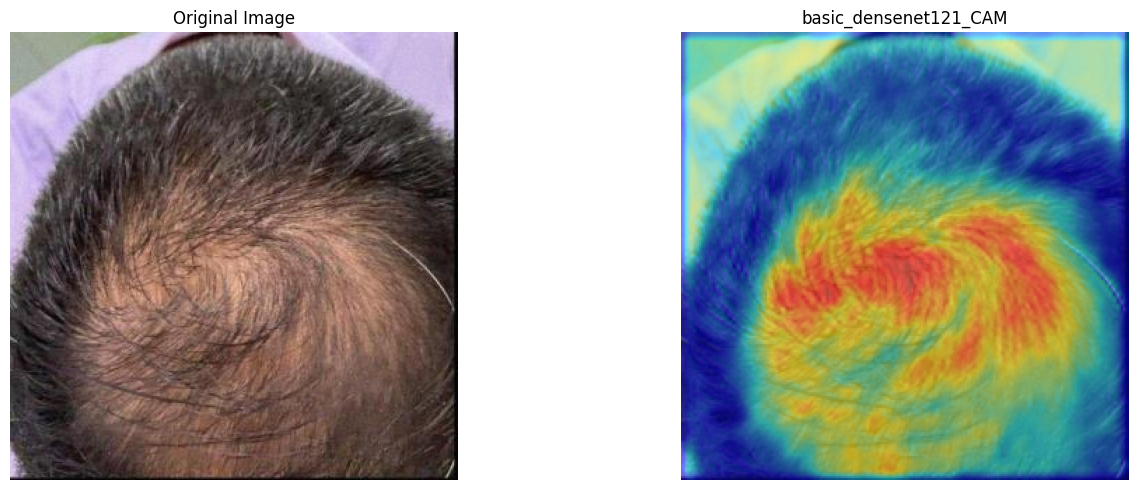

In [9]:
# 이미지 로드 및 전처리
image_path = "/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/4677.jpg"  # 분석할 이미지 경로
img_pil = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(img_pil).unsqueeze(0).to('cuda')  # [1, 3, 224, 224]
input_np = np.array(img_pil.resize((224, 224))).astype(np.float32) / 255.0

#Score-CAM 생성
cam = ScoreCAM(model=dens_model, target_layers=[target_layer])

#클래스 예측
with torch.no_grad():
    pred = dens_model(input_tensor).argmax().item()

#CAM 시각화 생성
grayscale_cam1 = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]
cam_image = show_cam_on_image(input_np, grayscale_cam1, use_rgb=True)

#시각화 출력
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img_pil)
axs[0].set_title("Original Image")
axs[1].imshow(cam_image)
axs[1].set_title(f"basic_densenet121_CAM")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

Yolov8 result 확인

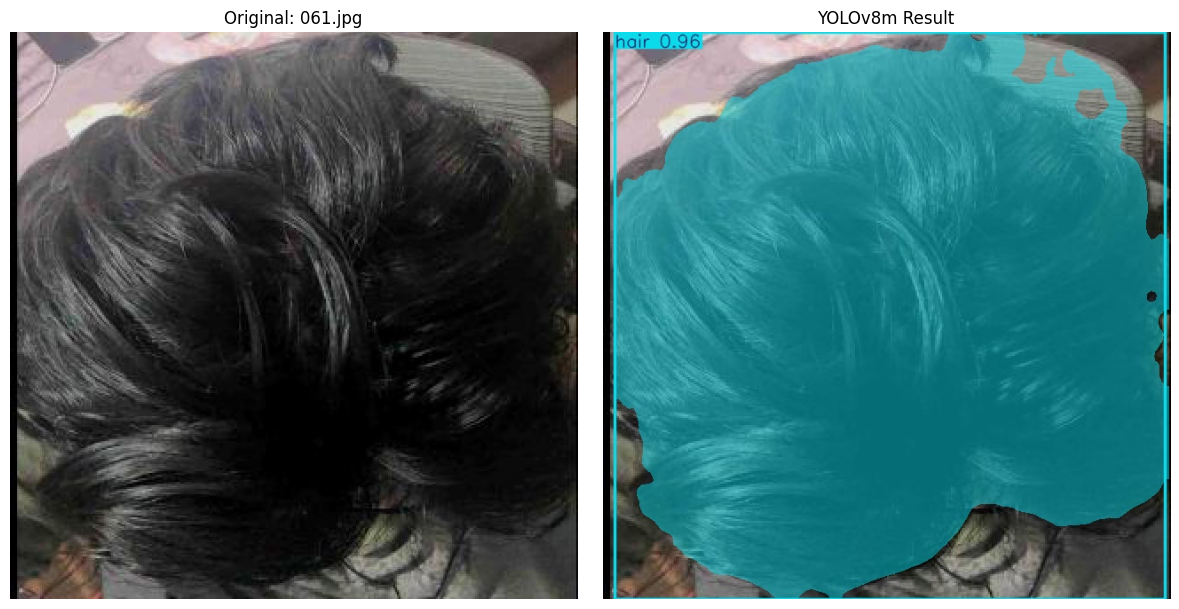

In [10]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# 1. 경로 설정
original_root = Path('/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test')
yolov8m_root = Path('/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/seg_output')

# 2. 이미지 목록 기준 (원본 이미지)
original_image_paths = sorted(list(original_root.glob("*.jpg")) + list(original_root.glob("*.png")))

# 3. 인덱스 설정
index = 6
if index >= len(original_image_paths):
    raise IndexError(f"index {index}는 이미지 개수 {len(original_image_paths)}를 초과합니다.")

# 4. 파일 경로 추출
original_image_path = original_image_paths[index]
image_name = original_image_path.name
yolov8m_path = yolov8m_root / image_name

# 5. 이미지 로딩
original_image = cv2.imread(str(original_image_path))
original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

if not yolov8m_path.exists():
    raise FileNotFoundError(f"YOLOv8m 결과 없음: {yolov8m_path}")
yolov8m_image = cv2.imread(str(yolov8m_path))
yolov8m_rgb = cv2.cvtColor(yolov8m_image, cv2.COLOR_BGR2RGB)
yolov8m_rgb = cv2.resize(yolov8m_rgb, (original_rgb.shape[1], original_rgb.shape[0]))

# 6. 시각화 (2개 나란히)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title(f"Original: {image_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(yolov8m_rgb)
plt.title("YOLOv8m Result")
plt.axis("off")

plt.tight_layout()
plt.show()

Yolov8 mask 시각화

In [13]:
def visualize_image_and_mask(image_path, mask_dir):
    #파일 이름에서 base 추출
    filename = os.path.splitext(os.path.basename(image_path))[0]
    mask_path = os.path.join(mask_dir, f"{filename}.png")

    #이미지와 컬러 마스크 로드
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('RGB')  # 컬러 마스크라고 명시

    #numpy 배열 변환
    image_np = np.array(image)
    mask_np = np.array(mask)

    #시각화
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_np)
    axs[1].set_title("Mask (RGB)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

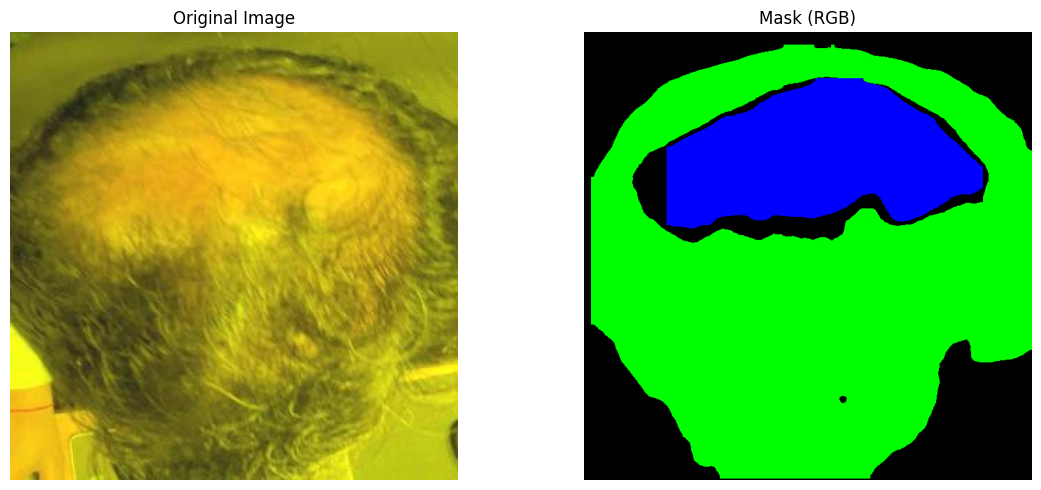

In [15]:
image_path = "/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/4308.jpg"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/hair_classification/data/test/class_mask"  # 같은 이름의 .png 파일이 존재해야 함
visualize_image_and_mask(image_path, mask_dir)